In [185]:
import torch
import matplotlib.pyplot as plt
import sys
from neuralop.models import FNO
from neuralop import Trainer
from neuralop.datasets import load_darcy_flow_small
from neuralop.utils import count_model_params
from neuralop import LpLoss, H1Loss
from utils import get_dataloaders, TensorDataset
import numpy as np
from timeit import default_timer
import torch.nn.functional as F
import torch.nn as nn
from losses import EnergyScore, KernelScore, VariogramScore
from models import FNO_reparam, FNO_complex
import gstools as gs
import scipy as sc

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [186]:
# Subsampling rate
sampling_rate = 2
ntrain = 2000
ntest = 200
batch_size = 64

data = np.load("data/grf_data.npy").astype(np.float32)

x_grid = np.linspace(0,20,256)
x_grid_test = np.linspace(10,20,128)
true_func = 2*np.sin(2*x_grid_test)

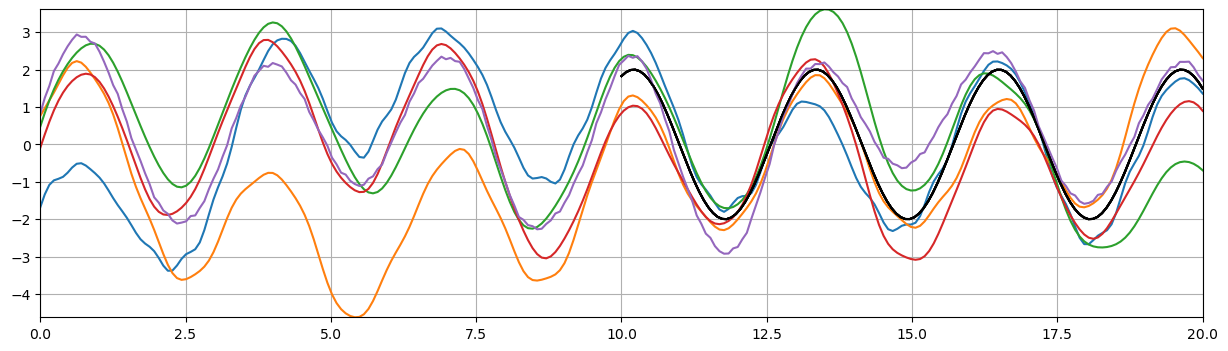

In [187]:
# Example plot
n_samples = np.random.randint(0,ntrain,5)

fig, axs = plt.subplots(figsize = (15,4))
index = 0
for i in n_samples:
    axs.plot(x_grid,data[i])
    axs.plot(x_grid_test, true_func, color = "black")


axs.grid(True)
axs.margins(0)

In [188]:
size_x = 128
x_data = torch.tensor(data[:,:size_x])
y_data = torch.tensor(data[:,size_x:])
#y_data = (y_data - y_data.mean()) / y_data.std()


# Add channel dimension
y_data = y_data[:, None, :]
x_data = torch.tensor(np.linspace(-10, 10, size_x), dtype=torch.float).repeat(data.shape[0],1,1)


# Add grid
gridx= torch.tensor(np.linspace(0, 10, size_x), dtype=torch.float)
gridx= gridx.reshape(1, 1, size_x)
x_data = torch.cat((x_data, gridx.repeat([data.shape[0], 1, 1])), dim=1)


x_train, y_train = x_data[:ntrain], y_data[:ntrain]
x_test, y_test = x_data[-ntest:], y_data[-ntest:]


train_loader = torch.utils.data.DataLoader(TensorDataset(x_train, y_train),
                                        batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(TensorDataset(x_test, y_test),
                                        batch_size=batch_size, shuffle=False)
test_data = [x_test, y_test]

# Losses and parameters

In [189]:
l2loss = LpLoss(d=1, p=2, L = 50.0)
energy_score = EnergyScore(d = 1, p = 2, type = "lp", L = 20.0)
#energy_score = KernelScore(d=1, p=2, type = "lp",  L = 20.0, kernel ="gauss", gamma = 10)
variogram_score = VariogramScore(p=1)

# Training parameters
epochs = 20
learning_rate = 0.0007
dropout_rate = 0.1

# MC dropout

In [190]:
def generate_mc_samples(model, x, shape, n_samples=100):
    samples = torch.zeros(*shape, n_samples)
    for i in range(n_samples):
        with torch.no_grad():
            samples[...,i] = model(x).detach()
    return samples

In [191]:
model = FNO(n_modes=(16,), hidden_channels=32, projection_channels=64,
             in_channels = 2, use_mlp=True, mlp_dropout=dropout_rate)
model = model.to(device)

n_params = count_model_params(model)
print(f'\nOur model has {n_params} parameters.')
sys.stdout.flush()



Our model has 93537 parameters.


In [192]:
optimizer = torch.optim.Adam(model.parameters(),
                                lr=learning_rate)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)

In [193]:
train_loss = torch.zeros(epochs)
test_loss = torch.zeros(epochs)

for ep in range(epochs):
    model.train()
    t1 = default_timer()
    train_mse = 0
    train_l2 = 0
    for sample in train_loader:
        x = sample["x"].to(device)
        y = sample["y"].to(device)

        optimizer.zero_grad()
        out = model(x)
        
        mse = F.mse_loss(out.view(batch_size, -1), y.view(batch_size, -1))
        l2 = l2loss(out.view(batch_size, -1), y.view(batch_size, -1))
        l2.backward() # l2 relative loss

        optimizer.step()
        train_mse += mse.item()
        train_l2 += l2.item()

    scheduler.step()
    model.eval()
    test_l2 = 0.0
    with torch.no_grad():
        for sample in test_loader:
            x = sample["x"].to(device)
            y= sample["y"].to(device)

            out = model(x)
            test_l2 += l2loss(out.view(batch_size, -1), y.view(batch_size, -1)).item()

    train_mse /= len(train_loader)
    train_l2 /= ntrain
    test_l2 /= ntest
    
    train_loss[ep] = train_l2
    test_loss[ep] = test_l2

    t2 = default_timer()
    print('Epoch-{}, Time-{:0.4f}, Train-MSE-{:0.4f}, Train-L2-{:0.4f}, Test-L2-{:0.4f}'
          .format(ep, t2-t1, train_mse, train_l2, test_l2))

Epoch-0, Time-0.8237, Train-MSE-1.9327, Train-L2-0.7733, Test-L2-0.6499
Epoch-1, Time-0.8137, Train-MSE-1.0868, Train-L2-0.5611, Test-L2-0.6327
Epoch-2, Time-0.7887, Train-MSE-1.0608, Train-L2-0.5488, Test-L2-0.6344
Epoch-3, Time-0.8135, Train-MSE-1.0400, Train-L2-0.5462, Test-L2-0.6368
Epoch-4, Time-0.8108, Train-MSE-1.0441, Train-L2-0.5453, Test-L2-0.6384
Epoch-5, Time-0.8190, Train-MSE-1.0342, Train-L2-0.5425, Test-L2-0.6291
Epoch-6, Time-0.8169, Train-MSE-1.0315, Train-L2-0.5420, Test-L2-0.6337
Epoch-7, Time-0.8199, Train-MSE-1.0317, Train-L2-0.5409, Test-L2-0.6298
Epoch-8, Time-0.8245, Train-MSE-1.0239, Train-L2-0.5400, Test-L2-0.6329
Epoch-9, Time-0.8308, Train-MSE-1.0355, Train-L2-0.5414, Test-L2-0.6405
Epoch-10, Time-0.8088, Train-MSE-1.0340, Train-L2-0.5414, Test-L2-0.6293
Epoch-11, Time-0.8246, Train-MSE-1.0199, Train-L2-0.5377, Test-L2-0.6266
Epoch-12, Time-0.8242, Train-MSE-1.0326, Train-L2-0.5397, Test-L2-0.6403
Epoch-13, Time-0.8253, Train-MSE-1.0175, Train-L2-0.5379, Tes

In [194]:
# %%
model.train()
""" Prediction """
pred = []
with torch.no_grad():    
    index = 0
    for sample in test_loader:
        x = sample["x"].to(device)
        y = sample["y"].to(device)
        out = generate_mc_samples(model, x, y.shape, n_samples=500)
        pred.append( out )


pred = torch.cat((pred))
mse_dropout = F.mse_loss(pred.mean(axis = -1).view(-1, size_x), y_test.view(-1, size_x)).item()
es_dropout = energy_score(pred, y_test).item()

print('MSE:', mse_dropout)
print('ES:', es_dropout)
dropout_pred = pred

MSE: 0.9136251211166382
ES: 3.6989755630493164


# PFNO

In [206]:
sample_model = FNO_reparam(n_modes=(16,), hidden_channels=32, projection_channels=64, in_channels=2, n_samples = 5,
                           use_mlp=True, mlp_dropout=0)
sample_model.to(device)
# Model and optimizer
optimizer = torch.optim.Adam(sample_model.parameters(), lr = learning_rate)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)

n_params = count_model_params(sample_model)
print(f'\nOur model has {n_params} parameters.')
sys.stdout.flush()


Our model has 97891 parameters.


In [207]:
train_loss = torch.zeros(epochs)
test_loss = torch.zeros(epochs)

for ep in range(epochs):
    sample_model.train()
    t1 = default_timer()
    train_l2 = 0
    for sample in train_loader:
        x = sample["x"].to(device)
        y = sample["y"].to(device)

        optimizer.zero_grad()
        out = sample_model(x)
        
        l2 = energy_score(out,y) #+ variogram_score(out, y)
        l2.backward() # l2 relative loss

        optimizer.step()
        train_l2 += l2.item()

    scheduler.step()
    test_l2 = 0.0
    with torch.no_grad():
        for sample in test_loader:
            x = sample["x"].to(device)
            y= sample["y"].to(device)

            out = sample_model(x)
            test_l2 += energy_score(out,y).item() #+ variogram_score(out,y).item()

    train_l2 /= ntrain
    test_l2 /= ntest
    
    train_loss[ep] = train_l2
    test_loss[ep] = test_l2

    t2 = default_timer()
    print('Epoch-{}, Time-{:0.4f}, Train-L2-{:0.4f}, Test-L2-{:0.4f}'
          .format(ep, t2-t1, train_l2, test_l2))

Epoch-0, Time-0.7647, Train-L2-0.0738, Test-L2-0.0579
Epoch-1, Time-0.8521, Train-L2-0.0500, Test-L2-0.0567
Epoch-2, Time-0.8822, Train-L2-0.0492, Test-L2-0.0564
Epoch-3, Time-0.8633, Train-L2-0.0495, Test-L2-0.0559
Epoch-4, Time-0.8638, Train-L2-0.0494, Test-L2-0.0567
Epoch-5, Time-0.8751, Train-L2-0.0491, Test-L2-0.0567
Epoch-6, Time-0.8765, Train-L2-0.0492, Test-L2-0.0555
Epoch-7, Time-0.7992, Train-L2-0.0492, Test-L2-0.0566
Epoch-8, Time-0.8799, Train-L2-0.0493, Test-L2-0.0562
Epoch-9, Time-0.8552, Train-L2-0.0491, Test-L2-0.0555
Epoch-10, Time-0.8710, Train-L2-0.0493, Test-L2-0.0554
Epoch-11, Time-0.8807, Train-L2-0.0492, Test-L2-0.0555
Epoch-12, Time-0.8706, Train-L2-0.0491, Test-L2-0.0561
Epoch-13, Time-0.8626, Train-L2-0.0491, Test-L2-0.0558
Epoch-14, Time-0.8647, Train-L2-0.0491, Test-L2-0.0560
Epoch-15, Time-0.8688, Train-L2-0.0489, Test-L2-0.0555
Epoch-16, Time-0.8726, Train-L2-0.0489, Test-L2-0.0558
Epoch-17, Time-0.8641, Train-L2-0.0489, Test-L2-0.0554
Epoch-18, Time-0.891

In [208]:
# %%
sample_model.eval()
""" Prediction """
pred = []
with torch.no_grad():    
    index = 0
    for sample in test_loader:
        x = sample["x"].to(device)
        y = sample["y"].to(device)
        out = sample_model(x, n_samples = 500).detach().cpu()
        pred.append( out )


pred = torch.cat((pred))
mse = F.mse_loss(pred.mean(axis = -1).view(-1, size_x), y_test.view(-1, size_x)).item()
es = energy_score(pred, y_test).item()

print('MSE:', mse)
print('ES:', es)

MSE: 0.9217295050621033
ES: 2.908937692642212


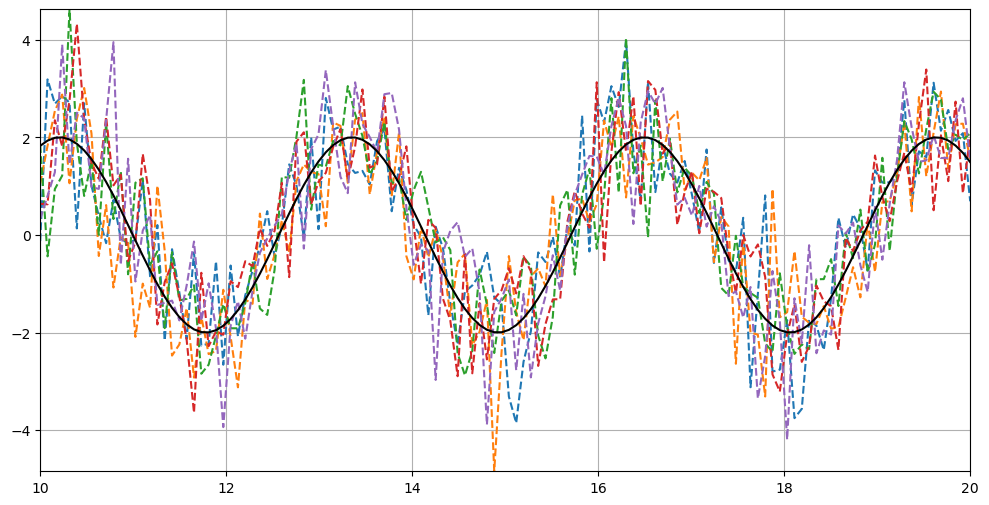

In [209]:
colormap = plt.cm.jet
colors = [colormap(i) for i in np.linspace(0, 1, 5)]

""" Plotting """ 
fig, axs = plt.subplots(figsize = (12, 6))
for i, sample in enumerate(np.random.choice(500,5)):
    axs.plot(x_grid_test,pred[0,0,:,sample].cpu().numpy(), '--', label='Prediction')
    index += 1
axs.plot(x_grid_test,true_func, color = "black")

axs.grid(True)
axs.margins(0)

In [210]:
# Comparison
print('MSE-Dropout:', mse_dropout)
print('ES-Dropout:', es_dropout)

print('MSE:', mse)
print('ES:', es)

MSE-Dropout: 0.9136251211166382
ES-Dropout: 3.6989755630493164
MSE: 0.9217295050621033
ES: 2.908937692642212


# Compare and analyze noise characteristics

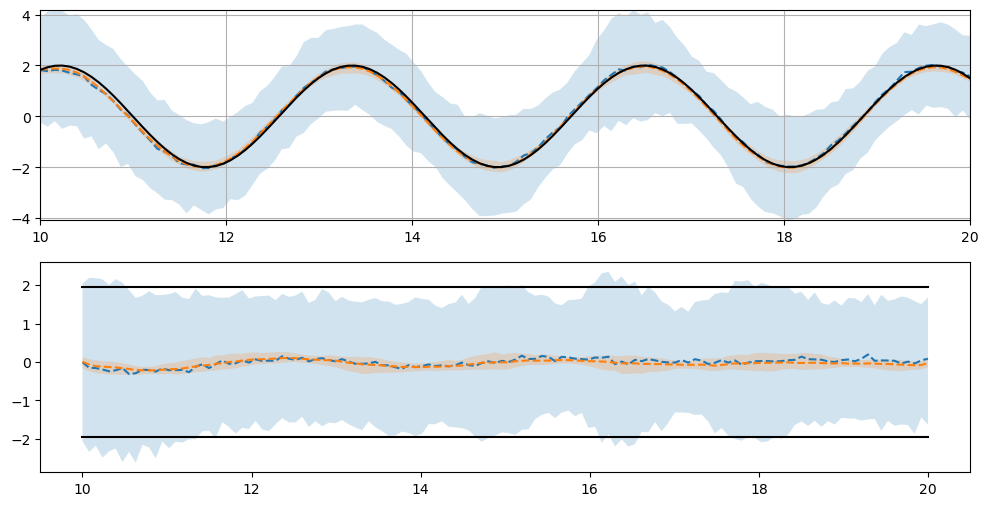

In [211]:
fig, axs = plt.subplots(2, 1, figsize = (12, 6))
i = 0

# Plot PFNO pred
axs[0].plot(x_grid_test,pred[i,0].mean(axis = -1).cpu().numpy(), '--', label='Prediction')
axs[0].fill_between(x_grid_test, pred[i,0].quantile(0.025, axis = -1).cpu().numpy(),
                    pred[i,0].quantile(0.975, axis = -1).cpu().numpy(), alpha=0.2)
# Plot dropout pred
axs[0].plot(x_grid_test,dropout_pred[i,0].mean(axis = -1).cpu().numpy(), '--', label='Prediction')
axs[0].fill_between(x_grid_test, dropout_pred[i,0].quantile(0.025, axis = -1).cpu().numpy(),
                dropout_pred[i,0].quantile(0.975, axis = -1).cpu().numpy(), alpha=0.2)
axs[0].plot(x_grid_test,true_func, color = "black")

# Plot Noise only
pfno_noise = pred[i,0].cpu().numpy() - np.expand_dims(true_func,1)
axs[1].plot(x_grid_test,pfno_noise.mean(axis = -1), '--', label='Prediction')
axs[1].fill_between(x_grid_test, np.quantile(pfno_noise,0.025, axis = -1),
                    np.quantile(pfno_noise,0.975, axis = -1), alpha=0.2)


dropout_noise = dropout_pred[i,0].cpu().numpy() - np.expand_dims(true_func,1)
axs[1].plot(x_grid_test,dropout_noise.mean(axis = -1), '--', label='Prediction')
axs[1].fill_between(x_grid_test, np.quantile(dropout_noise,0.025, axis = -1),
                    np.quantile(dropout_noise,0.975, axis = -1), alpha=0.2)

# Plot Gaussian quantile level
axs[1].plot(x_grid_test, np.repeat(sc.stats.norm().ppf(0.025), 128), color = "black")
axs[1].plot(x_grid_test, np.repeat(sc.stats.norm().ppf(0.975), 128), color = "black")

axs[0].grid(True)
axs[0].margins(0)

In [212]:
pfno_noise.var(axis = 1).mean()

0.8303159296096438

In [213]:
dropout_noise.var(axis = 1).mean()

0.007007849305457826

# Variogram estimation

In [214]:
model = gs.Matern(spatial_dim=1, nu = 1, var = 1, len_scale=2)
srf = gs.SRF(model)
bins = np.linspace(0,10,30)

In [215]:
# Estimate prediction for PFNO
var_samples = 500
pfno_list = [pfno_noise[:,sample] for sample in range(var_samples)]
dropout_list  = [dropout_noise[:,sample] for sample in range(var_samples)]

bin_center_pfno, gamma_pfno = gs.vario_estimate(x_grid_test, pfno_list, bins, mesh_type="structured")
bin_center_dropout, gamma_dropout = gs.vario_estimate(x_grid_test, dropout_list, bins, mesh_type="structured")

# Data estimation
data_list = [y_test[i,0] - true_func for i in range(200)]
bin_center_data, gamma_data= gs.vario_estimate(x_grid_test, data_list, bins, mesh_type="structured")

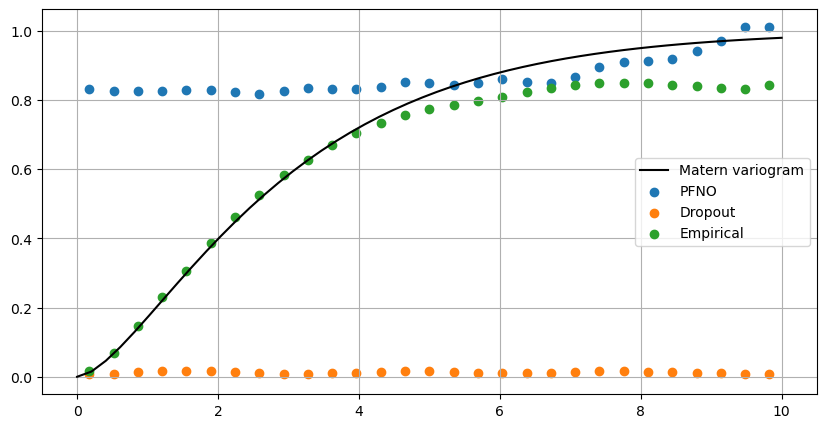

In [216]:
fig, axs = plt.subplots(figsize = (10,5))
model.plot(x_max=10, ax = axs, color = "black")
axs.scatter(bin_center_pfno, gamma_pfno, label = "PFNO")
axs.scatter(bin_center_dropout, gamma_dropout, label = "Dropout")
axs.scatter(bin_center_data, gamma_data, label = "Empirical")

axs.grid()
axs.legend()